# Import packages cell

Here all the packages utilized in this chapter:

In [37]:
import os
import tarfile
import urllib
import pandas as pd
import hashlib

%matplotlib inline 
from matplotlib import pyplot as plt
import numpy as np

And here i will import from a endpoint the dataset utilized.

## Step 1: How to get the dataset:

In [22]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path =os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

Using the ``fetch_housing_data`` function, let's call and store the data:

In [20]:
def load_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

Calling ``fetch_housing_data`` and ``load_data``:

In [49]:
fetch_housing_data()
data = load_data()

## Step 2: Looking your dataset

In [48]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [31]:
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Let's plot all columns histograms of this dataset.

array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

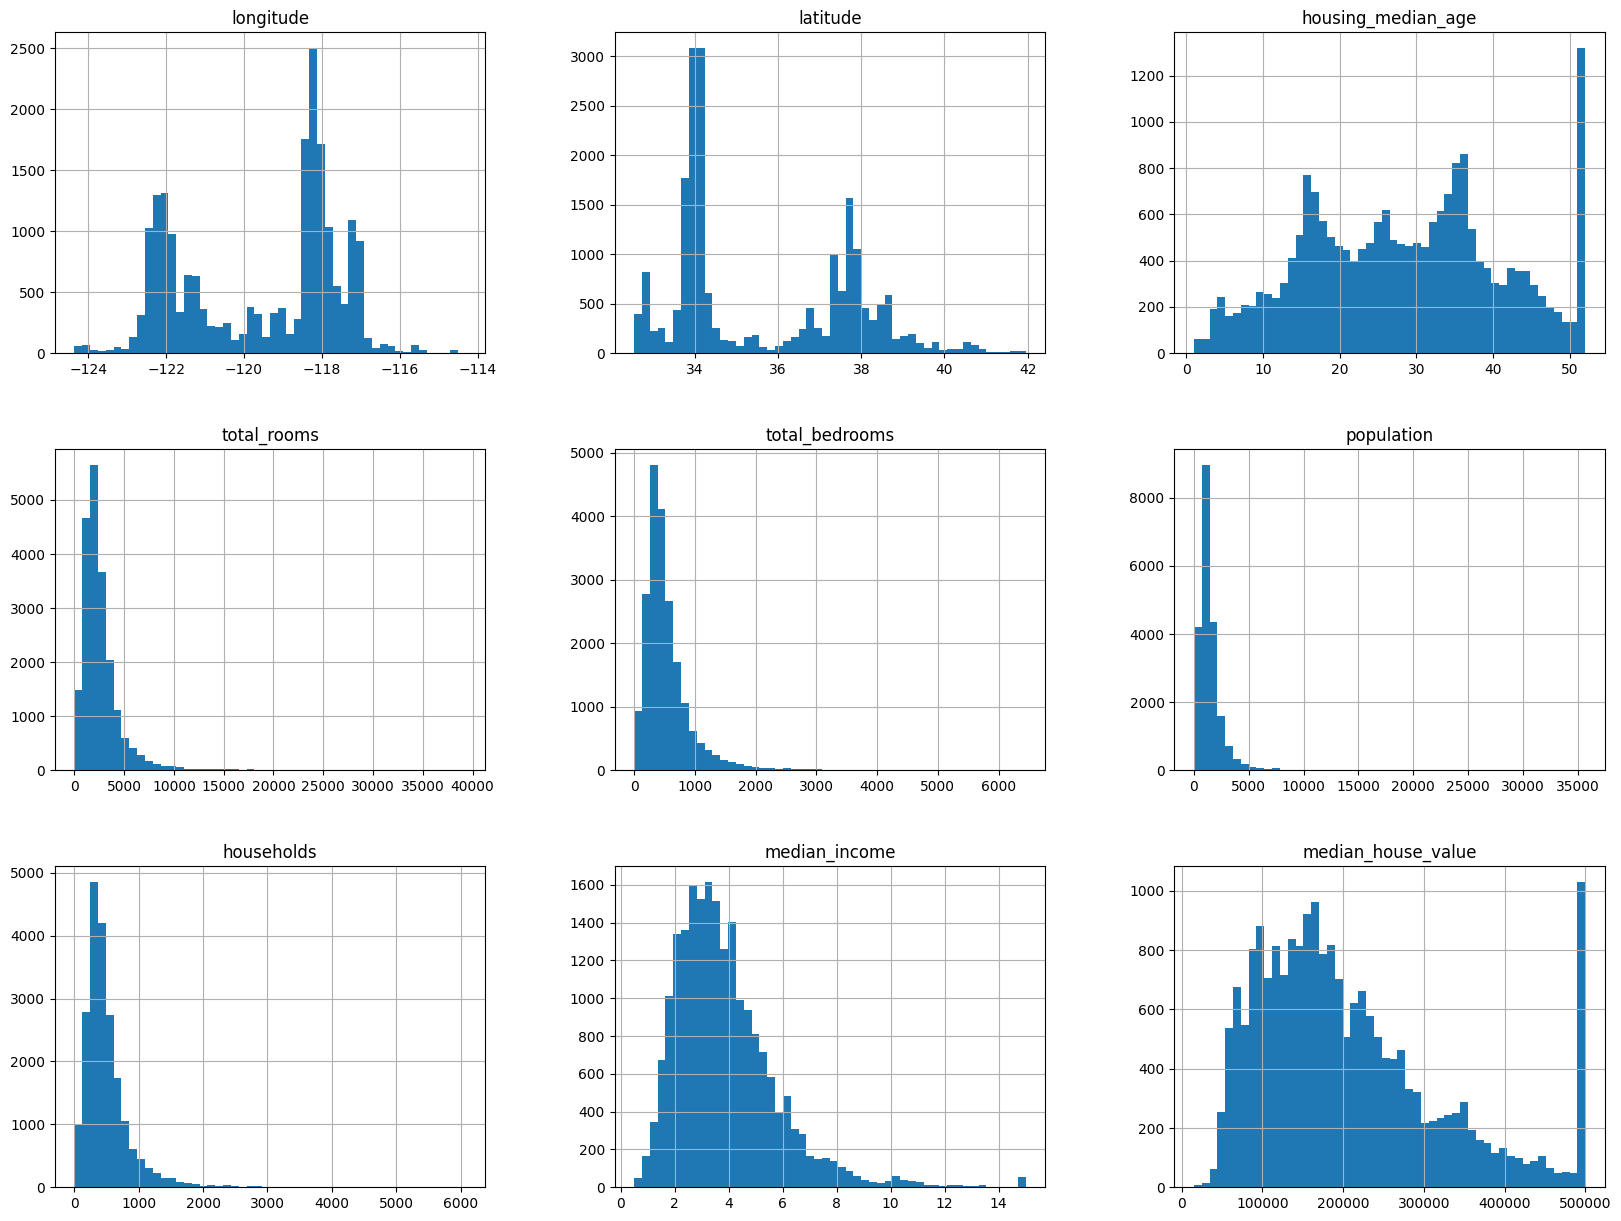

In [33]:
data.hist(bins=50, figsize= (20,15))

Now, we need to split the dataset in test data and train data. Keras and Scikit-Learn have native functions for this, but here the author opted to used Numpy to show some troubles you will find with the way you insert your dataset in the model.

## Step 3: spliting the dataset in a test subset and a training subset

In [35]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(data, 0.2)

print('train dataset lenght:',len(train_set))
print('test dataset lenght:',len(test_set))

train dataset lenght: 16512
test dataset lenght: 4128


but here we have a big problem: eventually, the model will see all the dataset, and this is not good for the model precision. A common solution is to use each instance's identifier to decide whether or not it should go in the test set.

In [43]:
def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

Unfortnately, the housing dataset does not have an identifier column. The simplest solution is to use the row index as the ID:

In [44]:
housing_with_id = data.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")


If you use the row index as a unique identifier, you need to make sure that new data gets appened to the end of the dataset, and no row ever gets deleted. If this is not possible, then you can try to use the most stable features to build a unique identifier.

In [46]:
housing_with_id["id"] = data["longitude"] * 1000 + data["latitude"]
train_set, train_test = split_train_test_by_id(housing_with_id, 0.2, "id")

As previously mentioned, Scikit-Learn has a function to automatically split the dataset for us.

In [47]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

This method generate fine samples if your dataset is large enough(especially relative to the nubmer of attributes). 
For small datasets, using only a random set of data is not good, because you run the risk of introducing a significant ***bias***.
A good example to understand what you need to do is when a survey company decides to call 1000 people to ask them a few questions, they don't just pick 1000 people randomly in a phone booth. They try to ensure that these 1000 people are representative of the whole population. For example, the US population is composed of 51.3% female and the remainder by male. This is called ***stratified sampling***: the population is divided into homogeneous subgroups called *strata*, and the right number of instances is sampled from each stratum to guarantee that the test set is representative of the overall population.

Let's take a important feature: **median income**.  It is important to have a sufficient number of instances in your dataset for each stratum, or else the estimate of the stratum's importance may be biased. This means that you should not have too many strata, and each stratum should be large enough.

In [50]:
data["income_cat"] = np.ceil(data["median_income"] / 1.5)
data["income_cat"].where(data["income_cat"] < 5, 5.0, inplace=True)

This two line of code creates an income category attribute by dividing the median income by 1.5 (to limit the number of income categories), and rounding up using ``np.ceil``, and then merging all the categories greater than 5 into category 5.

Now you are ready to do stratified sampling based on the income category. For this you can use Scikit-Learn's ``StratifiedShuffledSplit`` class

In [52]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["income_cat"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]

To remove the column you added, execute:

In [54]:
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

## Step 4: Visualize to realize

Let's create a copy of strat_train_set to play withouy harming:


In [55]:
dummy = strat_train_set.copy()

We can do a lot of things with this data to better visualization of the information.

### Geographical Data Visualization

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

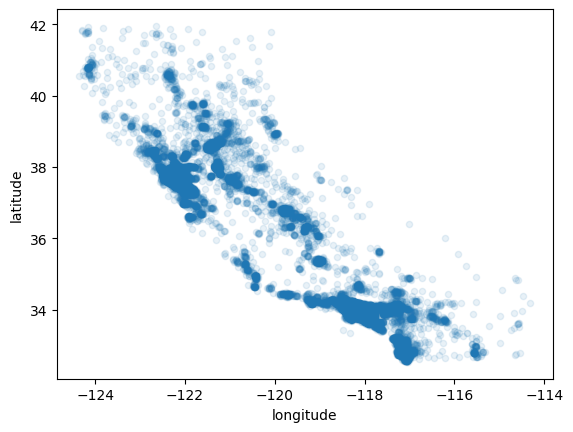

In [57]:
dummy.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

This plotting looks like State of California, abd we cab see the high_density areas (Bay Area around Los Angeles and San Diego).

This plot can be better for visualization. Now, let's look at the housing prices in this map. The radius of each circle represents the district's population, and the color represents the price.

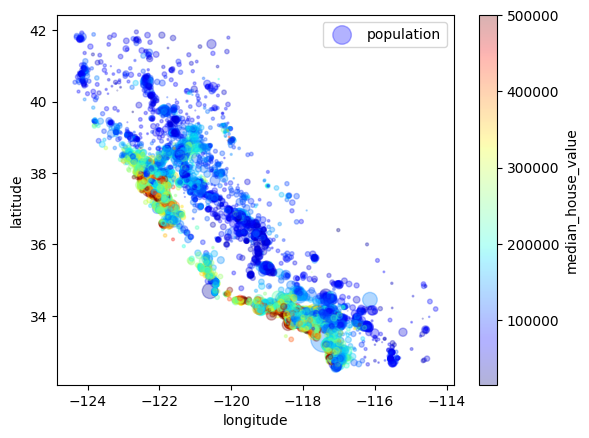

In [58]:
dummy.plot(kind="scatter", x="longitude", y="latitude", alpha=0.3,
          s=dummy["population"]/100, label="population", 
          c="median_house_value", cmap=plt.get_cmap("jet"),colorbar=True)

plt.legend()

By this graph, we can clearly read that the house prices are very much related to the location (The most expensive houses are close of the ocean) and to the population density. 

### Correlations

sinse the dataset is not to large, we can easily compute the standard correlation coefficient (called *Pearson's r*)

In [59]:
corr_matrix = dummy.corr()

Take a look in this variable:

In [60]:
# for exemple:

corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

This concept about correlation is the same concept discussed in SStochastic Process, but in the book we can se a interesting figure about the correlation. Note that correlation = 0 means no ***linear correlationship***.

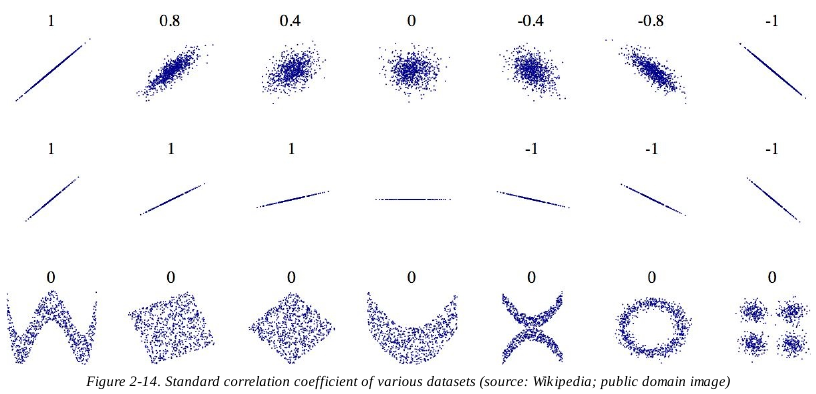

We can use ``scatter_matrix`` from Pandas to see this correlationship in graph mode.

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

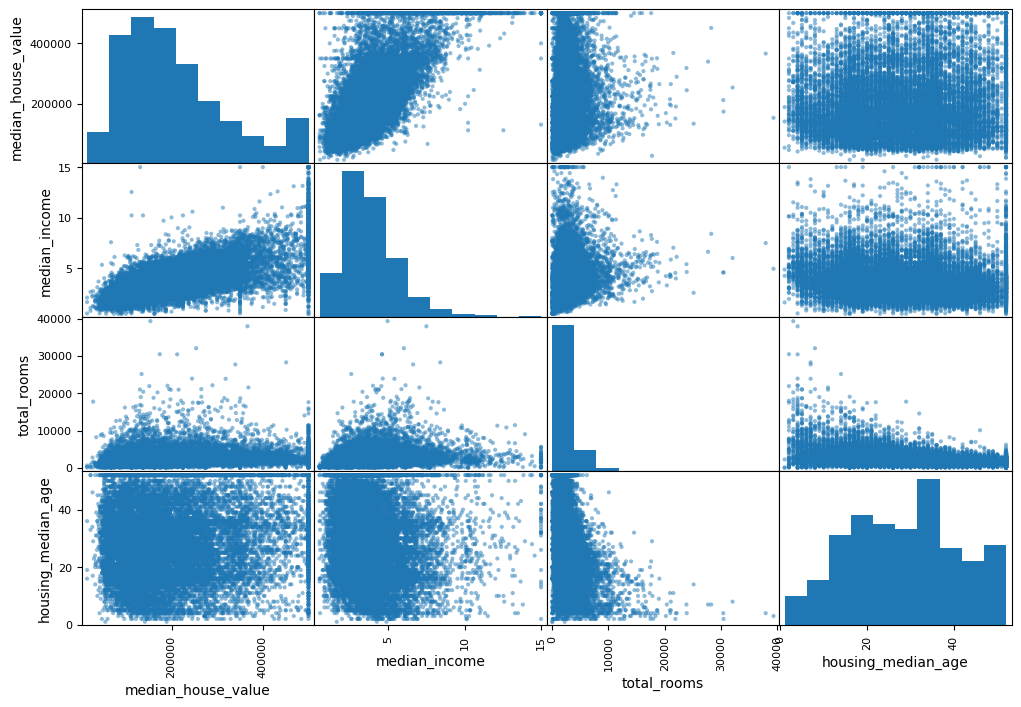

In [64]:
attributes = ["median_house_value", "median_income", "total_rooms",
             "housing_median_age"]
pd.plotting.scatter_matrix(dummy[attributes], figsize=(12,8))

Here, the correlation is indeed very string; you can clearly see the upward trend and the points are not too dispersed. A second thing we can see here, is the line patterns in the plots. Let's take the second graph, in first line (median_income x median_house_value). We can see a horizontal line at $\$$ 500,000, But this plot reveals ohter less obvius straight line: a horizontalline around $\$$ 350,000, perhaps one around $\$$ 280,000, and a few more below that. We may remove the corresponding districts to prevent our algorithms from learning to reproduce these data quirks.

## Next step: Prepare the Data

For the next notebook i will study the Scikit-Learn pipeline to prepare the Data, this is, Data Cleaning and Transformers for improve the dataset.